In [1]:
#ABILITà Informatiche
#dati Veneto blocco 21

In [4]:
pip install emcee

Note: you may need to restart the kernel to use updated packages.


In [185]:
import numpy as np
import imageio
import matplotlib
import scipy
from scipy.optimize import minimize
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
import json
import emcee
%matplotlib notebook

In [186]:
indata = open('dpc-covid19-ita-regioni.json')
dati = json.load(indata)

In [187]:
dati[20]

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 5,
 'denominazione_regione': 'Veneto',
 'lat': 45.43490485,
 'long': 12.33845213,
 'ricoverati_con_sintomi': 12,
 'terapia_intensiva': 4,
 'totale_ospedalizzati': 16,
 'isolamento_domiciliare': 16,
 'totale_positivi': 32,
 'variazione_totale_positivi': 0,
 'nuovi_positivi': 32,
 'dimessi_guariti': 0,
 'deceduti': 1,
 'casi_da_sospetto_diagnostico': None,
 'casi_da_screening': None,
 'totale_casi': 33,
 'tamponi': 2200,
 'casi_testati': None,
 'note': None,
 'ingressi_terapia_intensiva': None,
 'note_test': None,
 'note_casi': None,
 'totale_positivi_test_molecolare': None,
 'totale_positivi_test_antigenico_rapido': None,
 'tamponi_test_molecolare': None,
 'tamponi_test_antigenico_rapido': None,
 'codice_nuts_1': None,
 'codice_nuts_2': None}

In [188]:
len(dati)

21252

In [189]:
data_tot = []
contagi_tot = []

for i in range(1012):
    data_tot.append(dati[20 + i*21]['data'])
    contagi_tot.append(dati[20 + i*21]['nuovi_positivi'])

<IPython.core.display.Javascript object>


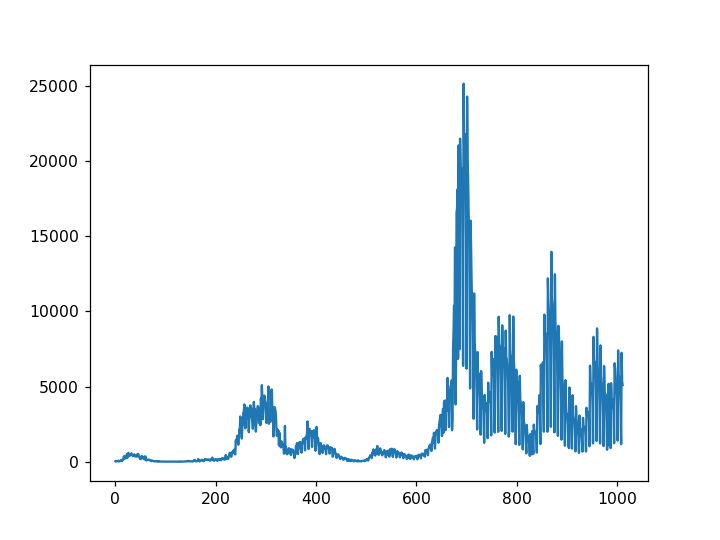

In [190]:
plt.figure()
plt.plot(contagi_tot)

<IPython.core.display.Javascript object>


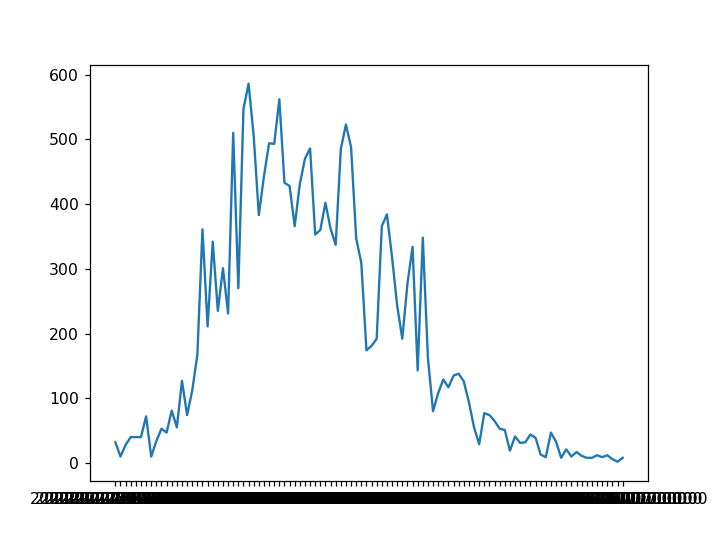

In [191]:
data = []
contagi = []
N = 100

for i in range(N):
    data.append(dati[20 + i*21]['data'])
    contagi.append(dati[20 + i*21]['nuovi_positivi'])
    
plt.figure()
plt.plot(data, contagi)

In [192]:
#funzione di gompertz

In [193]:
def gompertz(N, t0, ni, b, n0=1):
    '''
    calcolo della funzione di gompertz per N punti con t0 tempo di inizio, ni plateau della popolazione/dimensione popolazione, 
    b rate di crescita iniziale e n0 popolazione iniziale
    output funzione di gompertz e funzione di gompertz differenziale
    '''
    gomp = np.zeros(N)
    for t in range(N):
        gomp[t] = n0 * np.exp( np.log(ni[t]/n0) * ( 1 - np.exp( -b * (t-t0) ) ) )

    gomp_diff = np.zeros(N-1)
    for t in range(N-1):
            gomp_diff[t] = gomp[t+1] - gomp[t]
            
    return gomp, gomp_diff

<IPython.core.display.Javascript object>


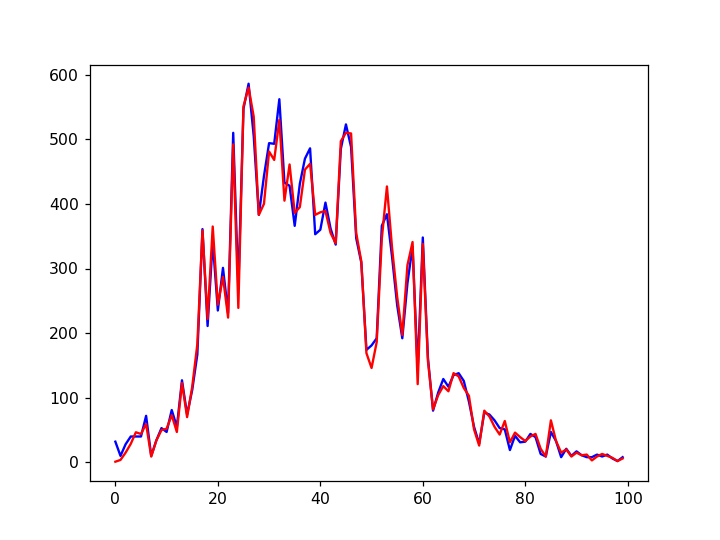

In [194]:
#prova
t0_1 = 0
b1 = 1
#ni1 = [x for x in contagi]
ni1 = np.random.poisson(lam=contagi, size=100)

prova1, diff1 = gompertz(N, t0_1, ni1, b1)

dati = [x for x in contagi]

plt.figure()
plt.plot(dati, color='blue')
plt.plot(prova1, color='red')

<IPython.core.display.Javascript object>


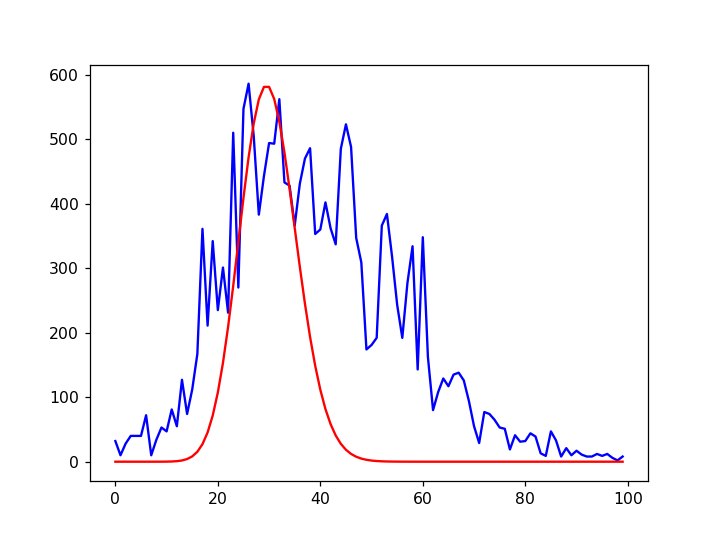

In [195]:
t0_2 = -1
b2 = 1
ni2 = scipy.stats.poisson.pmf(range(N), 30)

prova2, diff2 = gompertz(N, t0_2, ni2, b2)

plt.figure()
plt.plot(dati, color='blue')
plt.plot(8000 * prova2, color='red')

In [196]:
#poisson likelihood

In [197]:
def log_likelihood(dati, predizione):
    '''
    calcolo del logaritmo poisson-likelihood per i dati usando come modello predizione (entrambi array) 
    '''
    # -log(likelihood) = L
    L = np.sum(-np.log(predizione)*dati + predizione )
        
    # non c'è fattoriale perchè non serve per minimizzare (log(dati[i]!) non dipende dal modello)
    return L

In [198]:
#prova
stima = np.zeros(N)
stima = stima + 1.
print(log_likelihood(contagi, stima))

stima1 = prova1
print(log_likelihood(contagi, stima1))

stima2 = prova2
print(log_likelihood(contagi, stima2))

100.0
-89983.22694444936
144828.34431309358


<IPython.core.display.Javascript object>


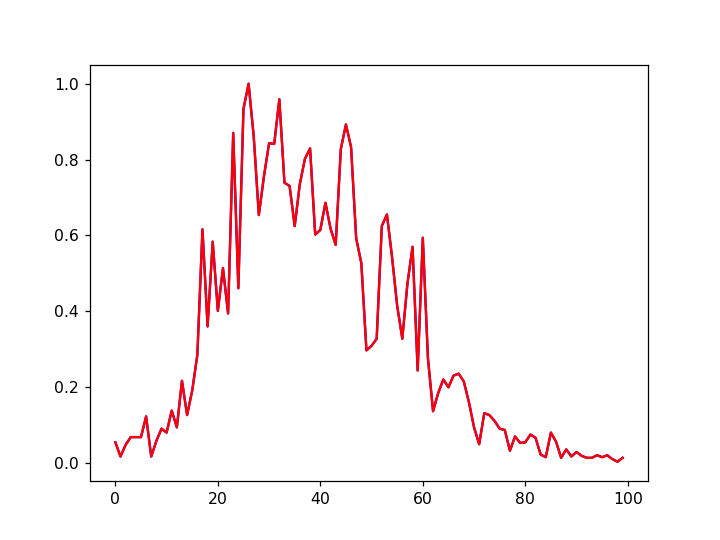

In [199]:
sol = minimize(log_likelihood, contagi, stima)

dati_nor = [x/max(dati) for x in dati]

sol_nor = sol.x/max(sol.x)

plt.figure()
plt.plot(dati_nor, color='blue')
plt.plot(sol_nor, color='red')

<IPython.core.display.Javascript object>


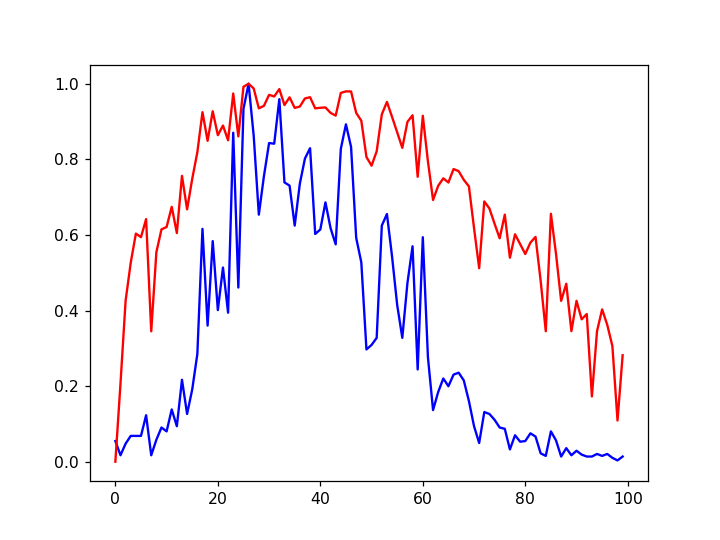

In [200]:
sol1 = minimize(log_likelihood, contagi, stima1)

dati_nor = [x/max(dati) for x in dati]

sol1_nor = sol1.x/max(sol1.x)

plt.figure()
plt.plot(dati_nor, color='blue')
plt.plot(sol1_nor, color='red')

<IPython.core.display.Javascript object>


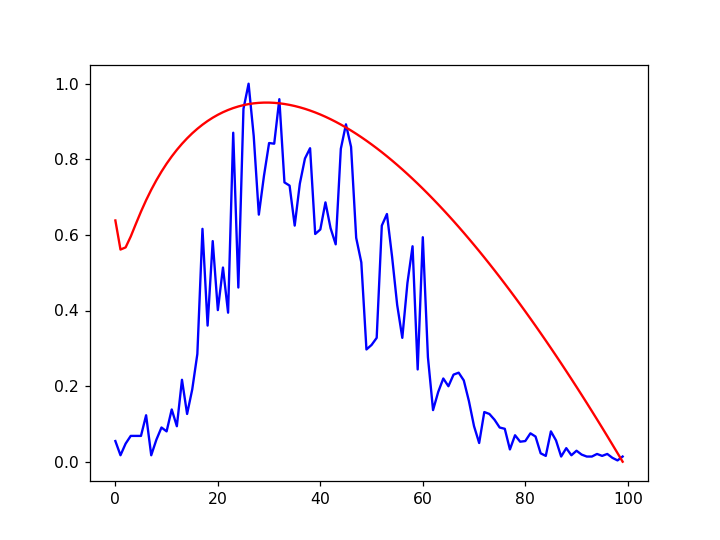

In [201]:
sol2 = minimize(log_likelihood, contagi, stima2)

dati_nor = [x/max(dati) for x in dati]

sol2_nor = sol2.x/abs(min(sol2.x)) + 1

plt.figure()
plt.plot(dati_nor, color='blue')
plt.plot(sol2_nor, color='red')

In [202]:
#emcee guida(https://emcee.readthedocs.io/en/stable/)

In [203]:
def log_probability(dati, predizione):
    N = len(dati)
    lp = scipy.stats.poisson.pmf(range(N), 30)
    return lp + log_likelihood(dati, predizione)

In [209]:
pos = sol1.x + 1e-4 * np.random.randn(32, N)

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability(dati, sol1.x), stima1)

sampler.run_mcmc(pos, 100, progress=True);

AttributeError: 'list' object has no attribute 'map'

In [210]:
sampler.run_mcmc?

In [211]:
emcee.EnsembleSampler?